# Imports

In [2]:
import streamlit as st
import pandas as pd
import numpy as np

import torch

from evaluate import load
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, set_seed, pipeline

In [3]:
set_seed(42)

In [4]:
torch.cuda.is_available()

True

## Model Initilization

In [6]:
model_name = "TheBloke/Llama-2-7B-chat-GPTQ"

# To use a different branch, change revision
# For example: revision="main"
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             torch_dtype=torch.float16)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

## Pipeline

In [23]:
"""
max_new_tokens: This parameter determines the maximum number of new tokens (words or subwords) that the model can generate as output. 

do_sample: Sampling during text generation can help add diversity to the generated summaries. 
Setting this parameter to True allows the model to sample tokens probabilistically during generation, 
which can lead to more varied outputs.

temperature: Temperature controls the randomness of the sampling process. 

top_p: Top-p (nucleus) sampling is useful for ensuring that the generated text remains fluent and relevant.

top_k: Top-k sampling limits the selection of tokens to the top k most likely tokens at each step. 
"""
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    do_sample=True,
    temperature=0.75,
    top_p=0.95,
    top_k=40,
    return_full_text = False
)

In [34]:
prompt_template1 = """
Summarize the text below and generate clear and concise summary

{text}

Summary:

"""

In [25]:
text = "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."
print(text)

The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.


## Output

In [43]:
result1 = pipe(prompt_template1.format(text=text))[0]['generated_text']
# llama_result = pipe(prompt_template)

In [45]:
print(result1) # Result from prompt template #1

The Eiffel Tower is 324 meters (1,063 ft) tall and the tallest structure in Paris. During its construction, it surpassed the Washington Monument to become the world's tallest man-made structure. It held this title for 41 years until the Chrysler Building in New York City was finished in 1930. It is now taller than the Chrysler Building by 5.2 meters (17 ft) due to the addition of a broadcasting aerial in 1957. Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.


In [46]:
prompt_template2="""{text}
Write a summary of the above text.

Summary:
"""

result2 = pipe(prompt_template2.format(text=text))[0]['generated_text']

In [47]:
print(result2) # Result from prompt tempalte #2

The Eiffel Tower is an iconic structure located in Paris, France, that stands at 324 meters (1,063 ft) tall. It was completed in 1889 and held the title of the tallest man-made structure in the world for 41 years. The tower's base measures 125 meters (410 ft) on each side, and it has a broadcasting aerial at the top that makes it taller than the Chrysler Building. The Eiffel Tower is excluding transmitters, the second tallest free-standing structure in France after the Millau Viaduct.


Prompt #1 is more longer by a few words and retains more info, than prompt #2.

## Evaluation

In [30]:
test_article = pd.read_csv('./test_article.csv')

references = test_article['summary']

We will evaluate this model with rouge and bertscore(Precision, Recall, and F1-Score)

ROUGE

rouge1: This metric represents the overlap of unigram (single words) between the generated summary and the reference summary. It measures the recall of unigrams in the generated summary compared to the reference summary.

rouge2: This metric represents the overlap of bigrams (pairs of words) between the generated summary and the reference summary. It measures the recall of bigrams in the generated summary compared to the reference summary.

rougeL: This metric measures the longest common subsequence (LCS) between the generated summary and the reference summary, considering the length of the LCS and the length of the reference summary. It's a recall-oriented metric that emphasizes longer overlapping sequences.

rougeLsum: This is the same as rougeL but computed separately for each summary sentence and then averaged.

BERTScore is an automatic evaluation metric for text generation that computes a similarity score for each token in the candidate sentence with each token in the reference sentence. It leverages the pre-trained contextual embeddings from BERT models and matches words in candidate and reference sentences by cosine similarity. (Taken from https://huggingface.co/spaces/evaluate-metric/bertscore)

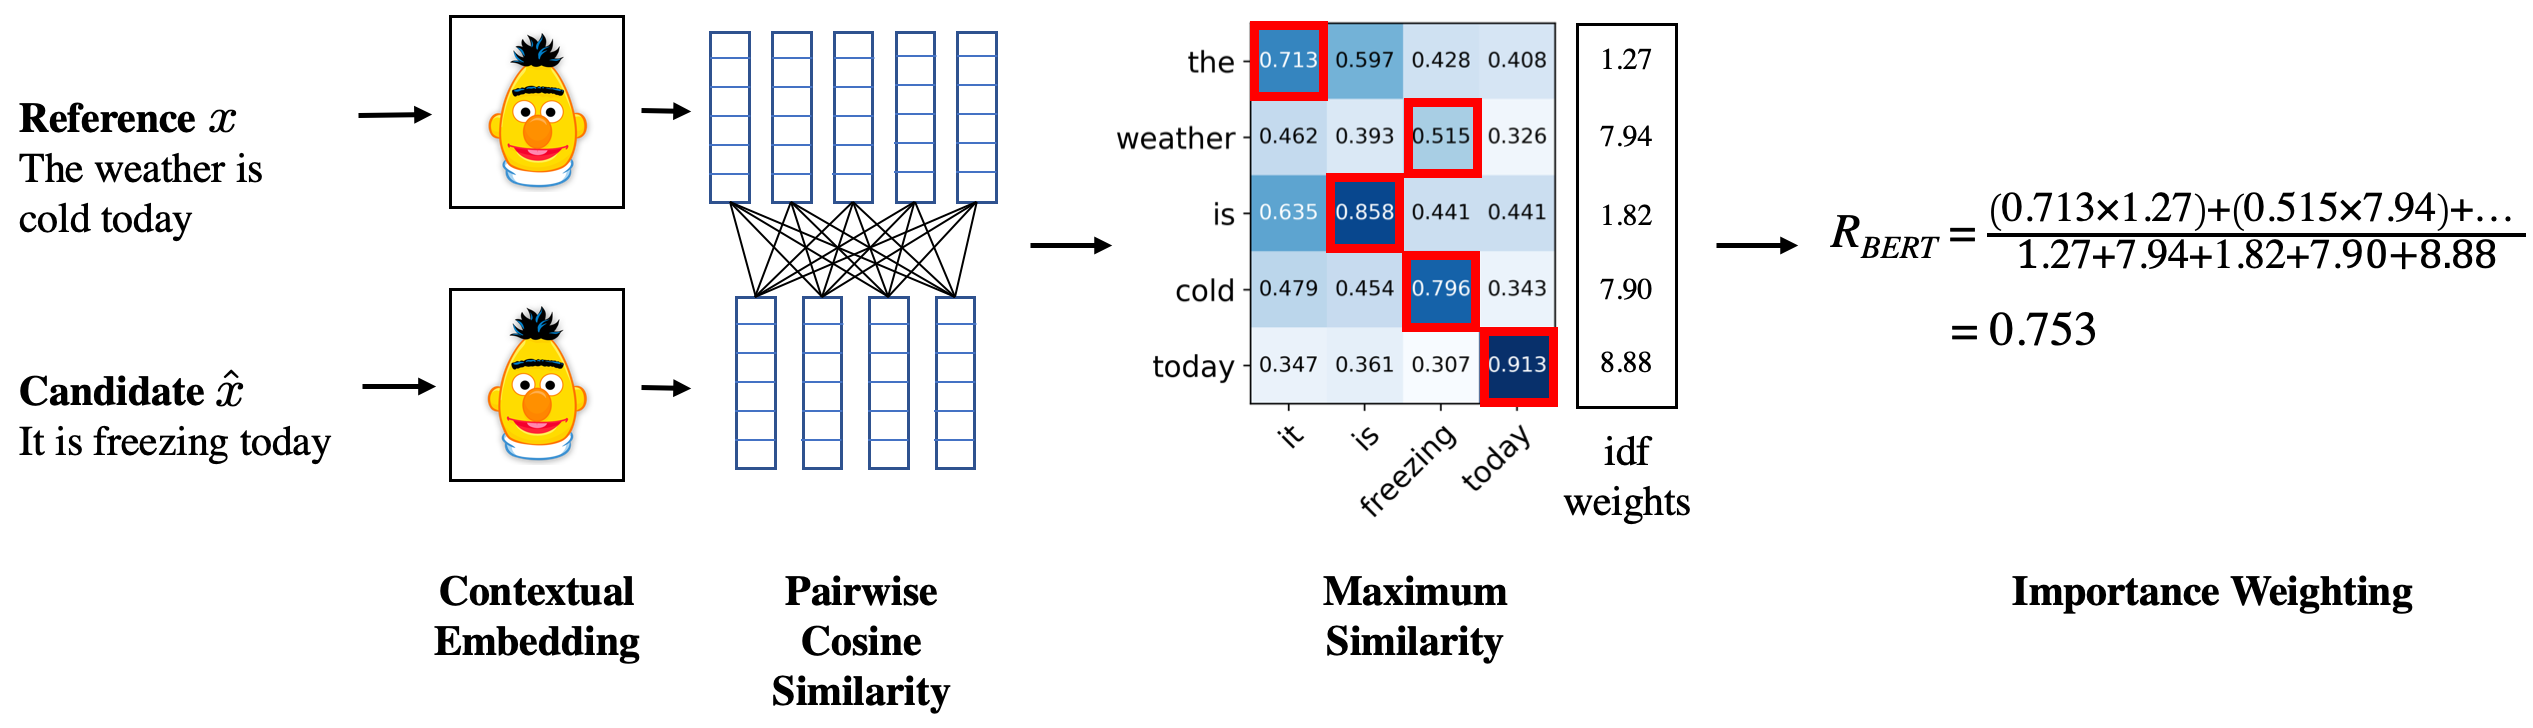
(image taken from https://github.com/Tiiiger/bert_score)

<b>Precision, Recall, F1-Score on LLM Context</b>

Precision: It measures how precise the summary is in capturing the key points and essential information from the original text.

Recall: It measures how much of the essential content from the original text is retained in the summary.

F1-Score: It provides a single metric that balances both precision and recall, offering an overall assessment of the summarization quality.

### Prompt #1

In [35]:
predicted = []
for article in test_article['article'].to_list():
    predicted.append(pipe(prompt_template1.format(text=article))[0]['generated_text'])

In [37]:
rouge = load('rouge')

rouge_score = rouge.compute(predictions=predicted, references=references)
print(rouge_score)

{'rouge1': 0.33728349495826704, 'rouge2': 0.15288333596445727, 'rougeL': 0.23778163747768613, 'rougeLsum': 0.23778163747768613}


In [38]:
bertscore = load("bertscore")
results = bertscore.compute(predictions=predicted, references=references, lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
print(f'Mean Precision: {np.mean(results["precision"])}')
print(f'Mean Recall: {np.mean(results["recall"])}')
print(f'Mean F1-Score: {np.mean(results["f1"])}')

Mean Precision: 0.8610816995302836
Mean Recall: 0.8911616802215576
Mean F1-Score: 0.8758023579915365


### Prompt #2

In [41]:
predicted = []
for article in test_article['article'].to_list():
    predicted.append(pipe(prompt_template2.format(text=article))[0]['generated_text'])
    
rouge_score = rouge.compute(predictions=predicted, references=references)
print(rouge_score)

{'rouge1': 0.24698462563663193, 'rouge2': 0.056457407277372425, 'rougeL': 0.13938924134554578, 'rougeLsum': 0.13938924134554578}


In [42]:
bertscore = load("bertscore")
results = bertscore.compute(predictions=predicted, references=references, lang="en")
print(f'Mean Precision: {np.mean(results["precision"])}')
print(f'Mean Recall: {np.mean(results["recall"])}')
print(f'Mean F1-Score: {np.mean(results["f1"])}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean Precision: 0.8434498310089111
Mean Recall: 0.859234611193339
Mean F1-Score: 0.8511845270792643


Based on scores, prompt #1 performs better than prompt #2 and based on a bit of human evaluation. I decided to use prompt #1 on the python script